# Tunnel++

***Goal***: To make an improved version of [Location+](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/) that incorporates pitch tunneling. <br>
**Author**: Jensen Holm <br>
**Date**: 2024

In [1]:
import statcast_pitches
import polars as pl
from plotnine import *
import os

LOCAL_DATA_DIR = os.path.join("..", "data")

## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches) 

In [2]:
pitches_df: pl.DataFrame = statcast_pitches.load()  # default is all pitches

pitches_df.sample(3, seed=42)

pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,…,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
str,datetime[μs],f64,f64,f64,str,i64,i64,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,f64,str,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,str,…,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,f64,f64,f64,f64
"""FF""",2016-06-24 00:00:00,94.9,-2.57,5.54,"""Withrow, Chris""",425766,519437,null,"""called_strike""",null,null,null,null,8,"""James Loney grounds out, first…","""R""","""L""","""R""","""ATL""","""NYM""","""S""",null,null,1,1,2016,-1.09,1.28,-0.14,1.67,null,null,null,2,7.0,"""Top""",…,5.7,447967,519437,452095,518692,607054,611177,430947,425796,542255,455976,54.5,null,null,null,null,null,null,null,58,3,"""4-Seam Fastball""",6,8,8,6,8,6,8,6,"""Infield shift""","""Standard""",219,0.0,-0.025,null,null
"""SL""",2017-04-13 00:00:00,85.7,-2.44,5.77,"""Kuhl, Chad""",643217,641771,null,"""called_strike""",null,null,null,null,13,"""Andrew Benintendi flies out sh…","""R""","""L""","""R""","""BOS""","""PIT""","""S""",null,null,0,0,2017,-0.25,0.34,-1.03,1.91,null,null,null,1,6.0,"""Bot""",…,6.0,490143,641771,455755,605137,594838,543281,474568,570256,516782,457705,54.51,null,null,null,null,null,null,null,45,1,"""Slider""",1,3,1,3,3,1,1,3,"""Standard""","""Standard""",230,0.0,-0.026,null,null
"""FF""",2022-06-26 00:00:00,96.6,-1.14,5.95,"""Knebel, Corey""",595751,608349,null,"""foul""",null,null,null,null,2,"""Jorge Alfaro strikes out swing…","""R""","""R""","""R""","""SD""","""PHI""","""S""",null,null,3,2,2022,-0.28,1.3,-0.05,3.28,null,null,null,2,7.0,"""Bot""",…,6.4,662254,608349,596117,656555,681082,664761,544369,656941,546318,663837,54.08,null,null,null,null,null,null,null,61,6,"""4-Seam Fastball""",5,6,5,6,6,5,5,6,"""Standard""","""Standard""",196,0.0,0.0,null,null


In [3]:
print(f"Number of pitches: {len(pitches_df):,}")
print(f"Date Range of pitches thrown: {pitches_df['game_date'].min().date()} - {pitches_df['game_date'].max().date()}")
print(f"Columns & Schema: {pitches_df.collect_schema()}")

Number of pitches: 7,011,277
Date Range of pitches thrown: 2015-04-05 - 2024-10-29
Columns & Schema: Schema({'pitch_type': String, 'game_date': Datetime(time_unit='us', time_zone=None), 'release_speed': Float64, 'release_pos_x': Float64, 'release_pos_z': Float64, 'player_name': String, 'batter': Int64, 'pitcher': Int64, 'events': String, 'description': String, 'spin_dir': Int64, 'spin_rate_deprecated': Int64, 'break_angle_deprecated': Int64, 'break_length_deprecated': Int64, 'zone': Int64, 'des': String, 'game_type': String, 'stand': String, 'p_throws': String, 'home_team': String, 'away_team': String, 'type': String, 'hit_location': Float64, 'bb_type': String, 'balls': Int64, 'strikes': Int64, 'game_year': Int64, 'pfx_x': Float64, 'pfx_z': Float64, 'plate_x': Float64, 'plate_z': Float64, 'on_3b': Int64, 'on_2b': Int64, 'on_1b': Int64, 'outs_when_up': Int64, 'inning': Float64, 'inning_topbot': String, 'hc_x': Float64, 'hc_y': Float64, 'tfs_deprecated': Int64, 'tfs_zulu_deprecated': Int

In [4]:
run_values_24 = pl.read_csv(
    os.path.join(LOCAL_DATA_DIR, "run_values.csv"),
).rename({"event": "events"}) # it is called 'events' in pitches_df

run_values_24.sample(10, seed=42)

events,balls,strikes,delta_run_exp
str,i64,i64,f64
"""double""",0,0,0.787066
"""single""",0,1,0.506624
"""hit_by_pitch""",1,2,0.453555
"""called_strike""",3,1,-0.077066
"""field_out""",2,0,-0.349643
"""foul""",3,1,-0.078992
"""ball""",0,1,0.025701
"""double""",3,0,0.690682
"""double""",3,1,0.618571


## Feature Engineering

adding the following features to `pitches_df`

| Name | Description |
|------|-------------|
| **year** | year that the pitch was thrown in |
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`| 

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

Adding `delta_run_exp` first

In [5]:
from utils import description_replace_mapping, event_replace_mapping


pitch_runs_df = pitches_df.join(
    other=run_values_24,
    on=["events", "balls", "strikes"],
    how="left",
)

mapped_des_pitches = pitch_runs_df.with_columns([
    pl.col("description")
    .replace_strict(description_replace_mapping, default=None)
    .alias("play_des"),
])

pitches_run_value_df = mapped_des_pitches.join(
    other=run_values_24,
    right_on=["events", "balls", "strikes"],
    left_on=["play_des", "balls", "strikes"],
    how="left",
    suffix="_des",
).with_columns([
    pl.when(pl.col("delta_run_exp").is_null())
    .then(pl.col("delta_run_exp_des"))
    .otherwise(pl.col("delta_run_exp"))
    .alias("delta_run_exp"),
])

pitches_run_value_df[[
    "pitch_type",
    "description",
    "balls",
    "strikes",
    "delta_run_exp",
]].describe()

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""6914201""","""7011277""",7.011277e6,7.011277e6,6.813807e6
"""null_count""","""97076""","""0""",0.0,0.0,197470.0
"""mean""",null,null,0.875581,0.888316,0.000004
"""std""",null,null,0.96683,0.827264,0.242346
"""min""","""AB""","""ball""",0.0,0.0,-1.661
"""25%""",null,null,0.0,0.0,-0.066
"""50%""",null,null,1.0,1.0,-0.017
"""75%""",null,null,1.0,2.0,0.036
"""max""","""SV""","""swinging_strike_blocked""",4.0,3.0,3.702


Mirroring LHP metrics as if they were thrown by RHP

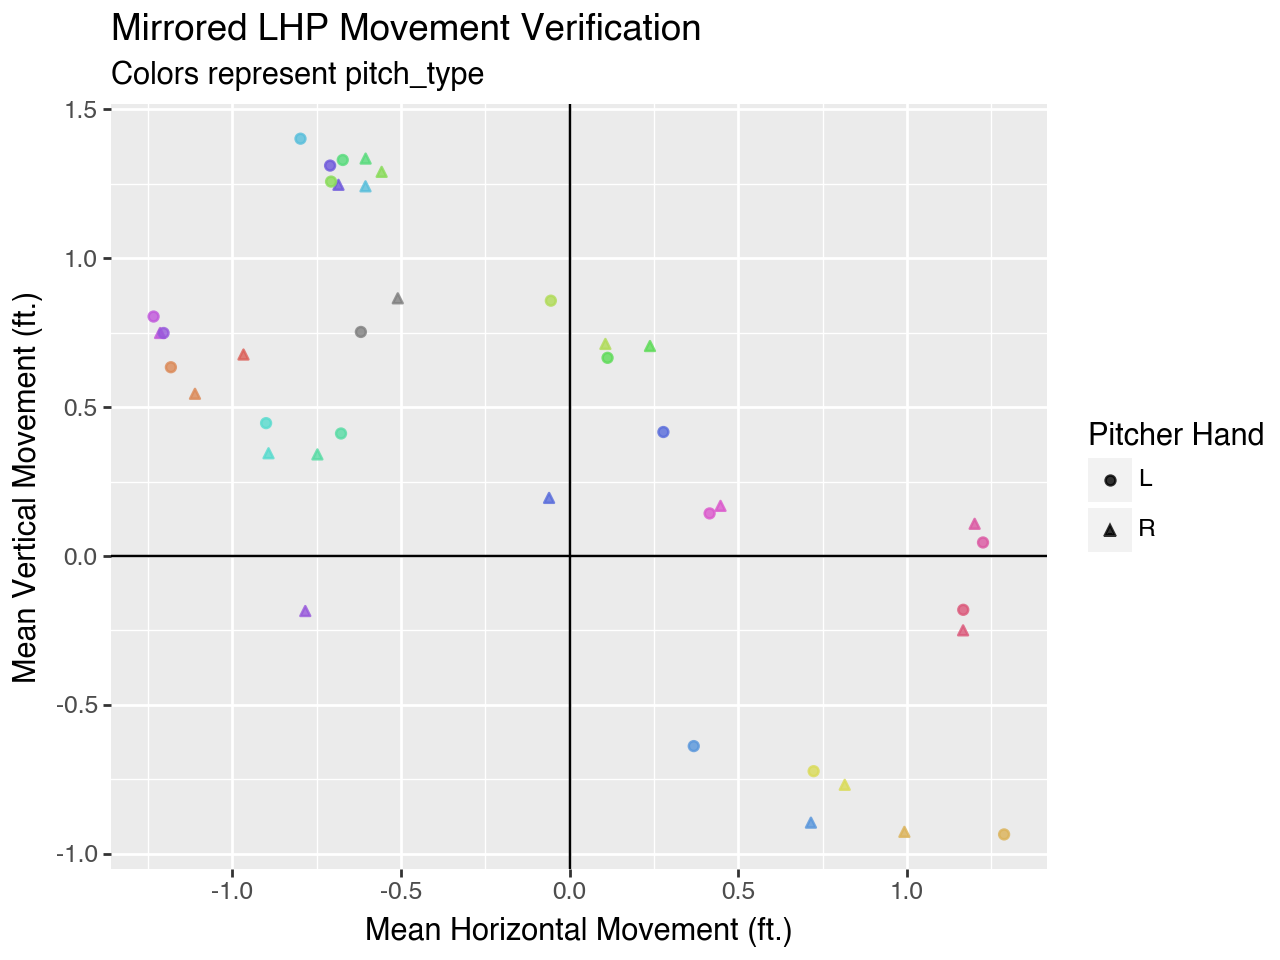

In [39]:
pitches_features_df = (
    pitches_run_value_df
    .with_columns([
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),
    ])
)

# for verification
movement_plt = (
    ggplot(
        pitches_features_df
        # .filter(pl.col("pitch_type").is_in(["FF", "CH", "KC", "SL"]))
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").mean().alias("mean_pfx_x"),
            pl.col("pfx_z").mean().alias("mean_pfx_z"),
        ),
        aes(x="mean_pfx_x", y="mean_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point(alpha=0.8)
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + guides(color="none")
    + labs(
        title="Mirrored LHP Movement Verification",
        x="Mean Horizontal Movement (ft.)",
        y="Mean Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now!